# 라이브러리 불러오기

In [1]:
# ! pip install -U imbalanced-learn scikit-learn
# !pip install gensim
# ! pip install optuna

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
import matplotlib.pyplot as plt

from gensim.models import FastText
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import TreebankWordTokenizer # 표준 토큰화
from nltk.corpus import stopwords # 불용어 제거
from nltk.stem import WordNetLemmatizer # 기본 형태로 변환
from imblearn.under_sampling import NeighbourhoodCleaningRule

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding 
from sklearn.linear_model import LogisticRegression
import optuna
from tensorflow.keras.initializers import Constant
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/sample_submission.csv')

In [4]:
display(train_df.head())
display(test_df.head())

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [5]:
train_df.groupby('first_party_winner').size()

first_party_winner
0     829
1    1649
dtype: int64

# 데이터 전처리

## 단어 처리

In [6]:
# 문자 처리
cat_cols = ['first_party', 'second_party', 'facts']

# \b : 단어 경계, W* : 길이가 0이상이고 단어가 아닌 문자, w{1} : 길이가 1인 단어
short_word = re.compile(r'\W*\b\w{1}\b') # 길이가 1인 단어 찾기
tokenizer = TreebankWordTokenizer() # 단어 단위로 토큰화
stopword = stopwords.words('english') # 불용어 리스트 가져오기
lemmatizer = WordNetLemmatizer() # 단어의 기본 형태 가져오기

In [7]:
def prepro1(df):
        df = df.strip() # 공백 제거
        df = df.lower() # 소문자로 변경
        df = df.replace(',', '')
        df = df.replace('.', '')
        

        content = short_word.sub('', df) # 한 글자 단어 제거
        com = re.compile(r"[^\uAC00-\uD7A30-9a-zA-Z\s]") # 한글, 영어, 숫자 및 공백 문자를 제외한 모든 문자를 매칭
        content = com.sub('', content)
        tokens = tokenizer.tokenize(content) # 단어 토큰화
        token_lst = []

        for token in tokens:
            if token not in stopword: #불용어 제거
                token_lst.append(lemmatizer.lemmatize(token, 'n')) # 단어의 기본 형태 가져오기
        return token_lst

In [8]:
train_df['first_party'] = train_df['first_party'].apply(prepro1)
train_df['second_party'] = train_df['second_party'].apply(prepro1)
train_df['facts'] = train_df['facts'].apply(prepro1)

test_df['first_party'] = test_df['first_party'].apply(prepro1)
test_df['second_party'] = test_df['second_party'].apply(prepro1)
test_df['facts'] = test_df['facts'].apply(prepro1)

In [9]:
all_text = train_df['first_party'].tolist() + train_df['second_party'].tolist() + train_df['facts'].tolist()

In [10]:
train_word_counts = train_df['facts'].apply(lambda x : len(str(x).split()))

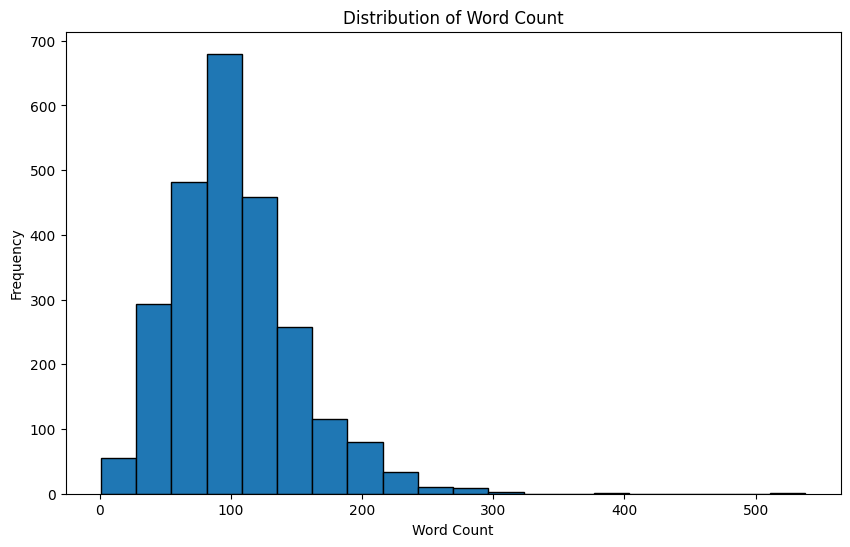

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(train_word_counts, bins=20, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.show()

## fasttext

'FastText'를 사용해 사전 훈련된 단어 임베딩을 가져오고, 이를 사용해 keras의 임베딩 레이어를 초기화한다

=> FastText 모델에서 얻은 단어 임베딩을 임베딩 행렬로 저장하고 있습니다. 이러한 저장된 임베딩 행렬은 후에 모델을 구축할 때 사용

In [12]:
model = FastText(all_text, vector_size = 100, window = 5, min_count = 1, workers = 4, sg = 1)

# tokenizer를 사용해 단어 인덱스를 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
word_index = tokenizer.word_index

In [13]:
embedding_dim = 100

In [14]:
# embedding matrix

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim)) # 단어 수 X 임베딩 차원

for word, i in word_index.items():
    if word in model.wv:
        embedding_vec = model.wv[word]
        embedding_matrix[i] = embedding_vec

In [15]:
# embeddings_initializer : 임베딩 레이어의 가중치를 초기화
# trainable = Fasle : 사전 훈련된 임베딩을 고정
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, embeddings_initializer = Constant(embedding_matrix), trainable = False)

In [16]:
def get_vec(model, texts):
    vects = []
    
    for text in texts:
        text_vects = []
        for word in text:
            if word in model.wv.key_to_index:
                text_vects.append(model.wv.get_vector(word))
        if len(text_vects) > 0:
            text_vects = np.mean(text_vects, axis = 0)
            vects.append(text_vects)
        else:
            vects.append(np.zeros(model.vector_size))
    
    return np.array(vects)

In [17]:
X_train_first = get_vec(model, train_df['first_party'])
X_train_second = get_vec(model, train_df['second_party'])
X_train_facts = get_vec(model, train_df['facts'])

X_train = np.concatenate([X_train_first, X_train_second, X_train_facts], axis = 1)
y_train = train_df['first_party_winner']

In [18]:
X_test_first = get_vec(model, test_df['first_party'])
X_test_second = get_vec(model, test_df['second_party'])
X_test_facts = get_vec(model, test_df['facts'])

X_test = np.concatenate([X_test_first, X_test_second, X_test_facts], axis = 1)

## 불균형 데이터 처리

In [19]:
from imblearn.over_sampling import SMOTE
X_smote, y_somte = SMOTE(sampling_strategy = 'auto', k_neighbors = 15, random_state = 123).fit_resample(X_train, y_train)
y_somte.value_counts()

first_party_winner
1    1649
0    1649
Name: count, dtype: int64

In [20]:
# X_ncr, y_ncr = NeighbourhoodCleaningRule(kind_sel = "all", n_neighbors = 5).fit_resample(X_train, y_train)
# print('train shape : {}, {}'.format(X_ncr.shape, y_ncr.shape))

In [21]:
# y_ncr.value_counts()

## train데이터 셋으로 train, val 데이터 셋으로 분리

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_somte, random_state = 123, test_size = 0.2)


# X_train, X_val, y_train, y_val = train_test_split(X_ncr, y_ncr, random_state = 123, test_size = 0.2)

print('Train shape : {}, {}'.format(X_train.shape, y_train.shape))
print(y_train.value_counts())

print()

print('Validation shape : {}, {}'.format(X_val.shape, y_val.shape))
print(y_val.value_counts())

Train shape : (2638, 300), (2638,)
first_party_winner
1    1328
0    1310
Name: count, dtype: int64

Validation shape : (660, 300), (660,)
first_party_winner
0    339
1    321
Name: count, dtype: int64


In [40]:
model = LogisticRegression(max_iter = 500, random_state = 42)
model.fit(X_train, y_train)
pred = model.predict(X_val)

print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.62      0.55      0.58       339
           1       0.58      0.64      0.61       321

    accuracy                           0.60       660
   macro avg       0.60      0.60      0.60       660
weighted avg       0.60      0.60      0.60       660



In [41]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

In [42]:
print('train accuracy : ', accuracy_score(y_train, y_train_pred))
print('validation accuracy : ', accuracy_score(y_val, y_val_pred))

train accuracy :  0.6167551175132676
validation accuracy :  0.5969696969696969


# 그리드서치

In [26]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 400, 500]
}

# 그리드 서치 모델 생성
grid_search = GridSearchCV(LogisticRegression(random_state = 123), param_grid, cv = 5, scoring = 'accuracy')

# 그리드 서치 수행
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
# 최적의 하이퍼파라미터와 결과 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'C': 10, 'max_iter': 200, 'penalty': 'l2', 'solver': 'sag'}
Best accuracy found:  0.5924932436317636


In [27]:
best_model = LogisticRegression(**best_params)
best_model.fit(X_train, y_train)
gri_pred = best_model.predict(X_val)
print(classification_report(y_val, gri_pred))

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       339
           1       0.61      0.62      0.61       321

    accuracy                           0.62       660
   macro avg       0.62      0.62      0.62       660
weighted avg       0.62      0.62      0.62       660



In [28]:
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

In [29]:
print('train accuracy : ', accuracy_score(y_train, y_train_pred))
print('validation accuracy : ', accuracy_score(y_val, y_val_pred))

train accuracy :  0.6376042456406369
validation accuracy :  0.6196969696969697


# 제출

In [30]:
# y_pred = model.predict(X_test)
# submission_df['first_party_winner'] = y_pred
# submission_df.to_csv('fasttext_NeighbourhoodCleaningRule_logit.csv', index = False)

In [33]:
y_pred = best_model.predict(X_test)
submission_df['first_party_winner'] = y_pred
submission_df.to_csv('fasttext_NeighbourhoodCleaningRule_logit_grid.csv', index = False)

In [39]:
# NumPy 배열을 판다스 Series로 변환
y_pred_series = pd.Series(y_pred)

# 클래스별 샘플 수 확인
print(y_pred_series.value_counts())

1    753
0    487
Name: count, dtype: int64
